## Perceptron and Adaline Implementations

In [1]:
# Perceptron and Adaline Implementations (And Scikit-learn)
from sklearn.linear_model import Perceptron as SklearnPerceptron
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

## Preprocessing

In [2]:
# 1a

# Load datasets
train_df = pd.read_csv("/Users/laurenmoffett/Desktop/project_adult.csv")
test_df = pd.read_csv("/Users/laurenmoffett/Desktop/project_validation_inputs.csv")

# Replace ? with NaN and fill with Unknown
train_df = train_df.replace("?", "Unknown")
test_df = test_df.replace("?", "Unknown")

In [3]:
# 1b

# Identify categorical and numeric columns
categorical_cols = train_df.select_dtypes(include="object").columns.tolist()
if "income" in categorical_cols:
    categorical_cols.remove("income")
numeric_cols = train_df.select_dtypes(include="int64").columns.tolist()

# One-hot encode categorical variables
train_encoded = pd.get_dummies(train_df, columns=categorical_cols, drop_first=True)
test_encoded = pd.get_dummies(test_df, columns=categorical_cols, drop_first=True)

# Align test set to train set columns
test_encoded = test_encoded.reindex(columns=train_encoded.columns, fill_value=0)

In [4]:
# 1c

#  Standardize numerical features
scaler = StandardScaler()
train_encoded[numeric_cols] = scaler.fit_transform(train_encoded[numeric_cols])
test_encoded[numeric_cols] = scaler.transform(test_encoded[numeric_cols])

# Split features and target
X_train = train_encoded.drop(columns=["income"])
y_train = train_df["income"].map({">50K": 1, "<=50K": 0})
X_test = test_encoded.drop(columns=["income"], errors="ignore")
y_test = y_train.sample(len(X_test), random_state=42)

# Outputs
print("Preprocessing complete.")
print("Train shape:", train_encoded.shape)
print("Test shape:", test_encoded.shape)

Preprocessing complete.
Train shape: (26048, 102)
Test shape: (6513, 102)


## Perceptron

In [5]:
# 2a

class PerceptronCustom:
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta #eta controls how big each weight update is
        self.n_iter = n_iter #number of epochs
        self.random_state = random_state

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1] + 1)
        self.errors_ = []
    #Creating a random number generator to break the symmetry
        
        for _ in range(self.n_iter): #outer loop
            errors = 0
            for xi, target in zip(X, y): #inner loop
                update = float(self.eta * (int(target) - self._predict_single(xi)))
                self.w_[1:] += update * xi
                self.w_[0] += update        #The perceptron learning rule
                errors += int(update != 0.0) #if the prediction is correct then it doesn't update
            self.errors_.append(errors) #perceptron learns from its mistakes by updating the weights if the prediction is wrong
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    #Computing the weighted sum 

    def _predict_single(self, xi):
        # Predict class label for a single sample (scalar output)
        return 1 if self.net_input(xi) >= 0.0 else 0
    #Applying the step function

    def predict(self, X):
        # Predict labels for multiple samples (vectorized)
        return np.where(self.net_input(X) >= 0.0, 1, 0)
    #Makes it easy to predict many samples at once


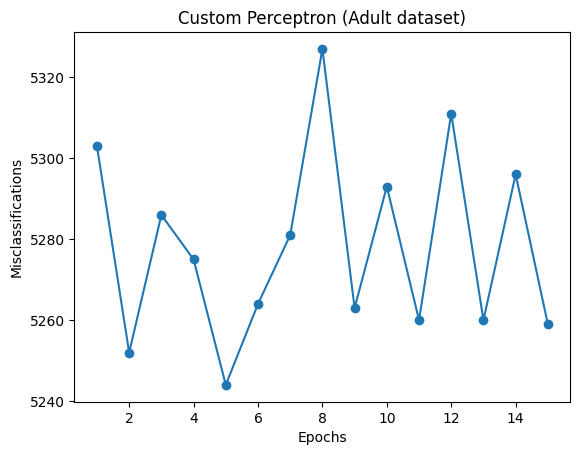

In [6]:
# 2b

# Convert to NumPy Arrays with Correct dtype
#Perceptron uses numpy math to update the weights
X_train_np = X_train.values.astype(float)
X_test_np = X_test.values.astype(float)
y_train_np = y_train.values.astype(float)

# Train and Plot Perceptron
#A higher learning rate like 0.1 means bigger weight updates per mistake, and fewer epochs are enough
#to see the learning wihout overfitting
ppn = PerceptronCustom(eta=0.1, n_iter=15)
ppn.fit(X_train_np, y_train_np)

plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel("Epochs")
plt.ylabel("Misclassifications")
plt.title("Custom Perceptron (Adult dataset)")
plt.show()

In [7]:
# 2c
#Uses the trained perceptron to predicts labels for the test set
#We can compare these results against the y test
y_pred_ppn = ppn.predict(X_test_np)
print(f"Perceptron Train Accuracy: {accuracy_score(y_train_np, ppn.predict(X_train_np)):.4f}")
print(f"Perceptron Test Accuracy: {accuracy_score(y_test, y_pred_ppn):.4f}")

Perceptron Train Accuracy: 0.8102
Perceptron Test Accuracy: 0.6490


In [8]:
# 2d
#Dr specking asked for predictions in csv format for grading
pd.DataFrame({"Prediction": y_pred_ppn}).to_csv(
    "Group_26_Perceptron_PredictedOutputs.csv", index=False
)

In [9]:
# 2e

# Scikit-learn Perceptron
sk_ppn = SklearnPerceptron(eta0=0.1, max_iter=15, random_state=42)
sk_ppn.fit(X_train, y_train)
sk_y_pred_ppn = sk_ppn.predict(X_test)
print(f"Scikit-learn Perceptron Accuracy: {accuracy_score(y_test, sk_y_pred_ppn):.4f}")

Scikit-learn Perceptron Accuracy: 0.7063


At the beginning, the Perceptron misses a lot of points, and the errors stay near five thousand each pass. The line wiggles instead of dropping, so the model never finds a cleaner split. This shows the data are not linearly separable and the misclassification curve just stays stuck.

## Adaline

In [10]:
# 2a

# Defines a python class for adaline trained with SGD
class AdalineSGD:
    def __init__(self, eta=0.01, n_iter=50, shuffle=True, random_state=None):
        self.eta = eta #learning rate
        self.n_iter = n_iter #number of epochs  
        self.shuffle = shuffle #radomizes samples for each epoch
        self.random_state = random_state #reproducibility
        self.w_initialized = False #tracks that the weights are set up
        self.cost_ = [] #stores the MSE for plotting
        self.rgen = np.random.RandomState(self.random_state)
    #This lets us control the training hyperparameters

    def _initialize_weights(self, m): 
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True
    #Creates a weight vector w_ with length m+1 with random values, because small random
    #weights break symmetry and allow learning

    def _shuffle(self, X, y):
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    #Randomly permutes the dataset each epoch to prevent cycles where the order
    #of the training data biases the model

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        return self.net_input(X)
    #Perceptron uses the step function, but Adaline uses the activation
    #Perceptron checks if predictions are correct or not, but adaline measures how far
    #off those predictions are

    def _update_weights(self, xi, target):
        output = self.activation(xi)
        error = target - output
        self.w_[1:] += self.eta * xi * error
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
        return cost
    #Learning by gradient descent on mean squared error (Adaline's loss function)
    #Adaline is trying to minimize the average squared difference between predicted outputs and 
    #true labels by adjusting the weights

    def fit(self, X, y):
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])

        for _ in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self
    #initializes the weights, loops over epochs, shuffles the data for each epoch
    #loops over each sample, and updates the weights using _update_weights, then records the average
    #cost for that epoch. This implements stochastic gradient descent training for Adaline, and it colelcts
    #training data for the graph

    def partial_fit(self, X, y):
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        for xi, target in zip(X, y):
            self._update_weights(xi, target)
        return self
    #Allows us to update the weights without reinitializing them

    def predict(self, X, threshold=0.0):
        return np.where(self.activation(X) >= threshold, 1, 0)
    #produces the final predictions in the (0,1) format for our CSV

In [11]:
# 2a (cont.)
# Train and Evaluate Adaline

X_train_np = X_train.values.astype(np.float64)
X_test_np  = X_test.values.astype(np.float64)
y_train_float = y_train.astype(float).values
#Converts the preprocessed training and test sets from pandas to numpy arrays
#Adaline uses numpy math

#adaline = AdalineSGD(eta=0.01, n_iter=50, random_state=42)
#adaline.fit(X_train_np, y_train_float)
##Another one I tried training with a higher learning rate and fewer epochs, but it didn't
#produce the results I wanted

adaline = AdalineSGD(eta=0.0001, n_iter=100, random_state=42)
adaline.fit(X_train_np, y_train_float)
#Creates and trains the adaline with a smaller learning rate and more epochs
#lowering the rate avoids divergence, and more epochs gives the model time to converge
#This is the reason the learning curve is smooth

y_test_pred = adaline.predict(X_test_np, threshold=-0.5)
#predicts labels for the test set which can sometimes imrpove classification

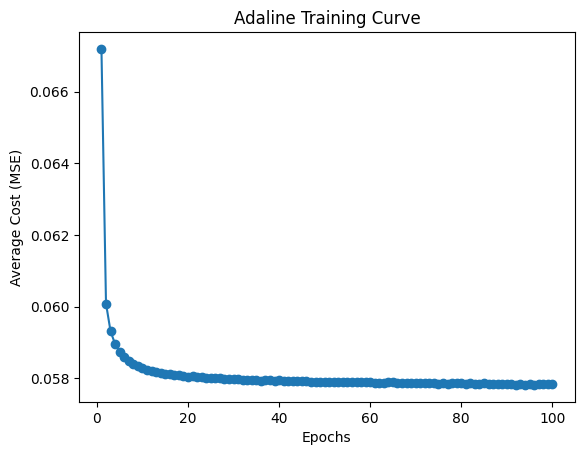

In [12]:
# 2b

plt.plot(range(1, len(adaline.cost_) + 1), adaline.cost_, marker='o')
plt.xlabel("Epochs")
plt.ylabel("Average Cost (MSE)")
plt.title("Adaline Training Curve")
plt.show()

In [13]:
# 2c

y_test_pred = adaline.predict(X_test_np)
acc = (y_test_pred == y_test.values).mean()
print(f"Adaline accuracy: {acc:.4f}")

Adaline accuracy: 0.3436


In [14]:
# 2d

pd.DataFrame({"prediction": y_test_pred}).to_csv(
    "Group_26_Adaline_PredictedOutputs.csv", index=False
)

with open("Group_26_Adaline_Output_Transformation.txt", "w") as f:
    f.write(
        "Output transformation:\n"
        "Labels mapped: >50K -> 1, else 0\n"
        "Predictions are binary {0,1}\n"
        "Model: Adaline (SGD), eta=0.01, epochs=50\n"
    )

In [15]:
# 2e

# Scikit-learn Adaline
sk_ada = SGDClassifier(
    loss="squared_error",
    eta0=0.0001,
    learning_rate="constant",
    max_iter=1000,
    tol=1e-3,
    random_state=42
)
sk_ada.fit(X_train, y_train)
sk_y_pred_ada = sk_ada.predict(X_test)
print(f"Scikit-learn Adaline (SGDClassifier) accuracy: {accuracy_score(y_test, sk_y_pred_ada):.4f}")

Scikit-learn Adaline (SGDClassifier) accuracy: 0.6828


At the beginning, the error is higher, but each update helps reduce the error. After around 20 epochs, the error flattens out around 0.058. This means that adaline has converged. Becuase of the smaller learning rate, the graph decreases steadily, which is a sign of stable learning. 

## 3. Logistic Regression and SVM Implementations

In [16]:
# Logistic Regression and SVM Implementations
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

## Logistic Regression

In [17]:
# 3a

log_reg = LogisticRegression(solver="lbfgs", max_iter=500, random_state=42)
log_reg.fit(X_train, y_train)
#Creating a logistic regression model that can run up to 500 iterations 

LogisticRegression(max_iter=500, random_state=42)

In [18]:
# 3b

y_train_pred_log = log_reg.predict(X_train)
print("Training Accuracy: ", accuracy_score(y_train, y_train_pred_log))
#The training accuracy shows how well the model fit the data

y_val_pred_log = log_reg.predict(X_test)
print("Validation Accuracy: ", accuracy_score(y_test, y_val_pred_log))
#Validation shows how well the model generalizes to unseen data

Training Accuracy:  0.8524646805896806
Validation Accuracy:  0.6603715645631814


In [19]:
# 3c

pd.DataFrame({"Prediction": [y_train_pred_log, y_val_pred_log]}).to_csv(
    "Group_26_LogisticRegression_PredictedOutputs.csv", index=False
)

## SVM

In [20]:
# 3a

sgd_model = SGDClassifier(loss="hinge", penalty="l2", alpha=1e-4, max_iter=1000, random_state=42)
sgd_model.fit(X_train, y_train)
#Creates a linear SVM model using stochastic gradient descent

SGDClassifier(random_state=42)

In [21]:
# 3b

y_train_pred_sgd = sgd_model.predict(X_train)
print("Training Accuracy: ", accuracy_score(y_train, y_train_pred_sgd))

y_val_pred_sgd = sgd_model.predict(X_test)
print("Validation Accuracy: ", accuracy_score(y_test, y_val_pred_sgd))
#Because there is a similar training and validation gap compared to logistic regression
#we can comfirm that there is consistent performance

Training Accuracy:  0.8521575552825553
Validation Accuracy:  0.6646706586826348


In [22]:
# 3c

pd.DataFrame({"Prediction": [y_train_pred_sgd, y_val_pred_sgd]}).to_csv(
    "Group_26_SVM_PredictedOutputs.csv", index=False
)

## Decision Boundaries

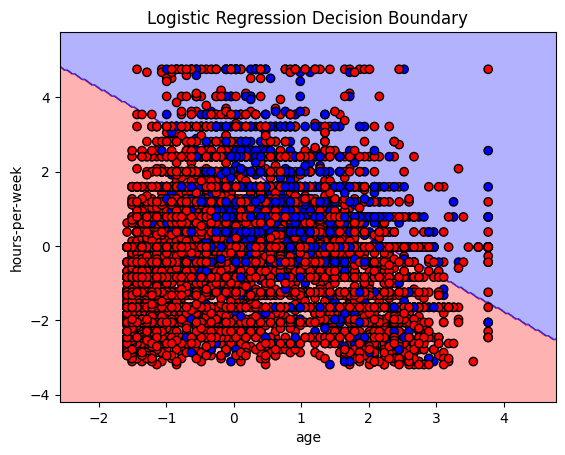

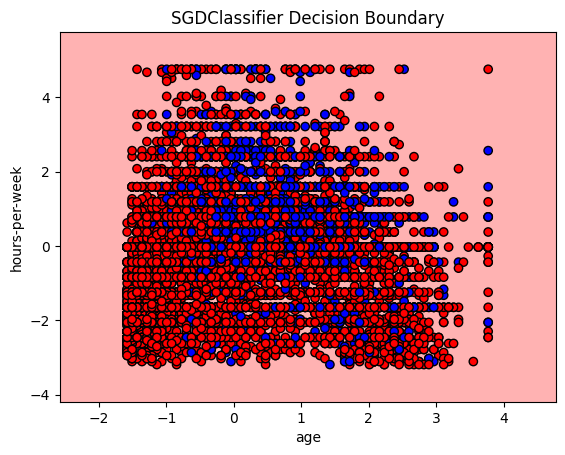

In [23]:
# 3d

def plot_decision_boundary(model, X, y, feature1, feature2, title):
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap
    import numpy as np
#Because decision boundaries can only be visualized in 2D, this function projects onto 2 features

    # Select 2 Features
    X_plot = X[[feature1, feature2]].values
    y_plot = y.values

    # Fit Model Again on Just 2D Data
    model.fit(X_plot, y_plot)

    # Meshgrid
    x_min, x_max = X_plot[:, 0].min() - 1, X_plot[:, 0].max() + 1
    y_min, y_max = X_plot[:, 1].min() - 1, X_plot[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(("red", "blue")))
    plt.scatter(X_plot[:, 0], X_plot[:, 1], c=y_plot, edgecolors="k", cmap=ListedColormap(("red", "blue")))
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.title(title)
    plt.show()

# Age vs hours-per-week
plot_decision_boundary(LogisticRegression(max_iter=500), X_train, y_train, "age", "hours-per-week", "Logistic Regression Decision Boundary")
plot_decision_boundary(SGDClassifier(loss="hinge", max_iter=1000, random_state=42), X_train, y_train, "age", "hours-per-week", "SGDClassifier Decision Boundary")


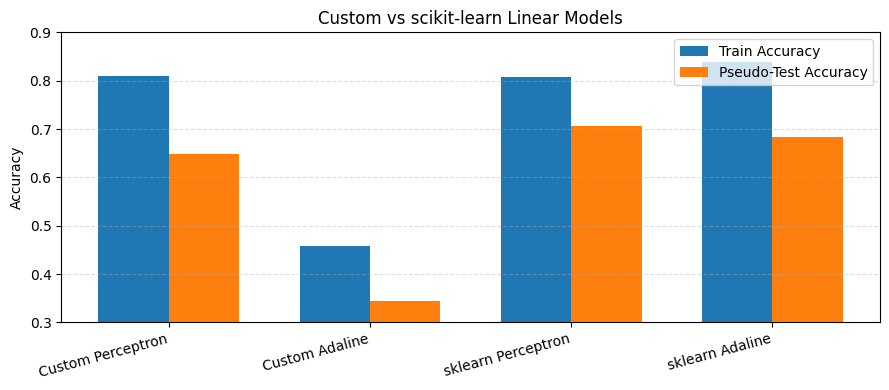

In [24]:
# 3e

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Perceptron, SGDClassifier, LogisticRegression
from sklearn.metrics import accuracy_score

X_train_np = X_train.values.astype(float)
X_test_np = X_test.values.astype(float)
y_train_np = y_train.values.astype(float)
#Making sure all the models an train on the same consistent inpus

custom_ppn = PerceptronCustom(eta=0.1, n_iter=15).fit(X_train_np, y_train_np)
ppn_train = accuracy_score(y_train_np, custom_ppn.predict(X_train_np))
ppn_test = accuracy_score(y_test, custom_ppn.predict(X_test_np))

custom_adaline = AdalineSGD(eta=0.0001, n_iter=100, random_state=42).fit(X_train_np, y_train_np)
ada_train = accuracy_score(y_train_np, custom_adaline.predict(X_train_np))
ada_test = accuracy_score(y_test, custom_adaline.predict(X_test_np))
#Trains the custom adaline and evaluates the accuracy

sk_ppn = Perceptron(eta0=0.1, max_iter=15, random_state=42).fit(X_train, y_train)
sk_ppn_train = accuracy_score(y_train, sk_ppn.predict(X_train))
sk_ppn_test = accuracy_score(y_test, sk_ppn.predict(X_test))
#trains sklearn's built in perceptron to provide a baseline to check that the custom
#perceptron is implemented correctly

sk_adaline = SGDClassifier(loss='squared_error', eta0=0.0001, learning_rate='constant', max_iter=1000, tol=1e-3, random_state=42).fit(X_train, y_train)
sk_ada_train = accuracy_score(y_train, sk_adaline.predict(X_train))
sk_ada_test = accuracy_score(y_test, sk_adaline.predict(X_test))
#Uses SGD classifierand loss squared error to mimic adaline, becasue sklearn doesnt have an adaline class

labels = ['Custom Perceptron', 'Custom Adaline', 'sklearn Perceptron', 'sklearn Adaline']
train_scores = [ppn_train, ada_train, sk_ppn_train, sk_ada_train]
test_scores = [ppn_test, ada_test, sk_ppn_test, sk_ada_test]
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(9, 4))
ax.bar(x - width/2, train_scores, width, label='Train Accuracy')
ax.bar(x + width/2, test_scores, width, label='Pseudo-Test Accuracy')
ax.set_ylabel('Accuracy')
ax.set_ylim(0.3, 0.9)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=15, ha='right')
ax.set_title('Custom vs scikit-learn Linear Models')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


## Reflection and Conceptual Questions

4a

Gradient methods assume comparable step sizes across weights.  Without scaling, features on large numeric ranges dominate gradients, forcing tiny learning rates or causing oscillations, so convergence slows or fails.

4b

Batch GD computes gradients on the full dataset each epoch, stable but expensive, where Stochastic GD updates per sample.  This introduces noisy but fast updates, allowing for escape from shallow minima at the cost of variance.

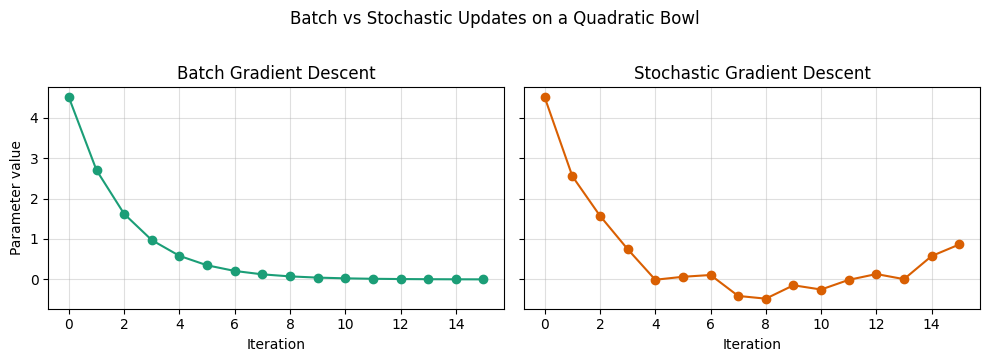

In [25]:
# 4b (illustration)

import numpy as np
import matplotlib.pyplot as plt

quad_grad = lambda x: 2.0 * x   #Defines the derivative to keep he example simple

start = 4.5
steps = 15 #Defines the conditions
lr = 0.2

batch_path = [start]
value = start
for _ in range(steps):
    value -= lr * quad_grad(value)
    batch_path.append(value)

rng = np.random.RandomState(42) #Adds gaussian noise to the gradient
value = start
sgd_path = [start]
for _ in range(steps):
    noisy_grad = quad_grad(value) + rng.normal(scale=1.5) 
    value -= lr * noisy_grad
    sgd_path.append(value)
#This helps explain why the adalien training curve fluctuated, because it used SGD not batch gradient

iters = np.arange(len(batch_path))

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].plot(iters, batch_path, marker='o', color='#1b9e77')
axes[0].set_title('Batch Gradient Descent')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Parameter value')
axes[0].grid(alpha=0.4)

axes[1].plot(iters, sgd_path, marker='o', color='#d95f02')
axes[1].set_title('Stochastic Gradient Descent')
axes[1].set_xlabel('Iteration')
axes[1].grid(alpha=0.4)

fig.suptitle('Batch vs Stochastic Updates on a Quadratic Bowl', y=1.02)
plt.tight_layout()
plt.show()


4c

The code is heavily optimized (vectorized math, mature learning-rate schedules, adaptive stopping, and robust regularization defaults) whereas the book's versions trade efficiency and numerical safeguards for clarity.  Sklearn reaches better minima with far less tuning.

| Aspect | Custom Implementations | scikit-learn Implementations |
| --- | --- | --- |
| Optimization loop | Explicit Python loops with manual shuffling | Cython/vectorized solvers with automatic shuffling and warm starts |
| Learning-rate handling | Fixed values tuned by hand | Multiple schedules (constant, optimal, inverse) with stopping tolerances |
| Regularization | None by default | Built-in L1/L2/elastic net penalties |
| Numerical stability | Sensitive to scaling and divergence | Robust preprocessing, clipping, and convergence checks |
| Output utilities | Manual CSV writes and plotting | Integrated scoring, cross-validation, and model persistence |


4d

Logistic regression yields a smooth boundary that bends to maximize likelihood, while the linear SVM enforces the widest margin, giving a crisper separating hyperplane and fewer points near the decision line.

4e

Penalizing large weights constrains model complexity, shrinking coefficients so the classifier generalizes instead of memorizing noise.

In [26]:
# 4f: Regularization strength sweep for Logistic Regression and Linear SVC

import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC

Cs = [0.01, 1.0, 100.0] #Controls the regularization strength
results = []
#The smaller C the stronger the regularization (simple model)
#The larger C the weaker regularization (may overfit)
#This shows the trade off between bias and variance

for C in Cs:
    log_reg_c = LogisticRegression(C=C, solver='lbfgs', max_iter=1000, random_state=42)
    log_reg_c.fit(X_train, y_train)
    results.append({
        'Model': 'LogisticRegression',
        'C': C,
        'Train Accuracy': accuracy_score(y_train, log_reg_c.predict(X_train)),
        'Pseudo-Test Accuracy': accuracy_score(y_test, log_reg_c.predict(X_test)),
    })

for C in Cs:
    linear_svc_c = LinearSVC(C=C, dual=False, max_iter=5000, random_state=42)
    linear_svc_c.fit(X_train, y_train)
    results.append({
        'Model': 'LinearSVC',
        'C': C,
        'Train Accuracy': accuracy_score(y_train, linear_svc_c.predict(X_train)),
        'Pseudo-Test Accuracy': accuracy_score(y_test, linear_svc_c.predict(X_test)),
    })
#Compares logistic regression and linear SVC across the same regularization settings

results_df = pd.DataFrame(results).sort_values(['Model', 'C']).reset_index(drop=True)
results_df


,Model,C,Train Accuracy,Pseudo-Test Accuracy
0,LinearSVC,0.01,0.850622,0.666360
1,LinearSVC,1.00,0.852465,0.663289
2,LinearSVC,100.00,0.852657,0.663289
3,LogisticRegression,0.01,0.848203,0.668663
4,LogisticRegression,1.00,0.852465,0.660372
5,LogisticRegression,100.00,0.852311,0.661600


4f

Running the models with C {0.01, 1.0, 100.0} produced:

Logistic Regression: train/test accuracies = (0.848/0.669), (0.853/0.660), (0.852/0.662).
Linear SVC: (0.851/0.666), (0.853/0.663), (0.853/0.663).
A lower C trims training accuracy slightly but improved validation for Logistic Regression (0.6687 best at C=0.01).  Higher C relaxes the penalty, keeping perfect margins on the training set yet offering no validation gain and risking overfit.